# **Import Data & Libraries**

In [1]:
#library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df_day = pd.read_csv('/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/day.csv', index_col='dteday', parse_dates=True)
df_hour = pd.read_csv('/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/hour.csv', index_col='dteday', parse_dates=True)

In [3]:
df_day.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
df_hour.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# **Basic Data Information**

In [5]:
# printing information about data
df_day.info()
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   season      731 non-null    int64  
 2   yr          731 non-null    int64  
 3   mnth        731 non-null    int64  
 4   holiday     731 non-null    int64  
 5   weekday     731 non-null    int64  
 6   workingday  731 non-null    int64  
 7   weathersit  731 non-null    int64  
 8   temp        731 non-null    float64
 9   atemp       731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 91.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 16 columns):
 

The Bike Sharing dataset contains two primary dataframes, one with 731 entries representing daily aggregated data and another with 17,379 entries for hourly data. Both datasets are comprehensive, with all columns showing no missing values, indicating a high level of data completeness.

The data is well-structured, consisting mainly of numeric variables (integers and floats) along with a date column (dteday). The features include essential information about weather conditions, dates, times, and bike usage, categorized into casual and registered users, which can be aggregated to compute the total bike count (cnt).

The data is suitable for time series analysis and regression modeling. The availability of variables like the weather and temporal factors gaving an opportunity to explore and model the impact of environmental and seasonal patterns on bike rentals. The large dataset size, especially for the hourly data, provides a robust foundation for uncovering both short-term and long-term trends.

Future steps could involve to capture cyclical patterns (such as hourly, weekly, and monthly trends), examining correlations between weather variables and bike usage, and implementing predictive models to forecast demand and optimize bike availability.

In [6]:
# printing basic describtion about day and hour datasets
df_day.describe()
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


The descriptive statisticsit for both day and hour datasets shows a comprehensive overview of the distributions and characteristics of the features.

**Temporal Variables:** The "hr" column ranges from 0 to 23, indicating a 24-hour cycle. The "season" and "mnth" columns capture cyclical patterns across different times of the year, ranging from 1 (spring) to 4 (winter) and from 1 (January) to 12 (December), respectively.

**Categorical Features:** The "holiday", "weekday", "workingday", and "weathersit" variables provide information about whether a particular hour falls on a holiday or working day, the day of the week, and the weather situation. The low mean value for holiday (0.0288) indicates that bike sharing data predominantly represents non-holiday hours.

**Weather-Related Features:** The "temp" and "atemp" columns represent the normalized temperature and feels-like temperature, while 'hum" (humidity) and "windspeed" also play a role in understanding the impact of weather on bike rentals. The mean values suggest mild weather on average, but the maximum humidity and relatively high wind speeds might impact bike usage during extreme conditions.

**Bike Rental Variables:** The average number of "casual" and "registered" users per hour is 35.68 and 153.79, respectively, leading to a total average count ("cnt") of 189.46 bike rentals per hour. The standard deviations indicate considerable variability in bike usage, likely influenced by temporal, seasonal, and weather factors.


**Data Distribution:** The minimum and maximum values highlight the wide range of bike rentals, from no rentals at certain hours to a peak of 977 rentals in an hour. Additionally, the quartile values show that bike rentals are often concentrated at lower counts, with a significant increase in registered users compared to casual users.

This discribtion will help to model and identify key features that influence bike demand, explore hourly and daily trends, and forecast future bike usage effectively.

In [7]:
# If you want 'dteday' as a column
df_hour.reset_index(inplace=True)
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])  # This is now a valid column
df_hour['day_of_year'] = df_hour['dteday'].dt.dayofyear

# **Data Visualization and Distribution Analysis**

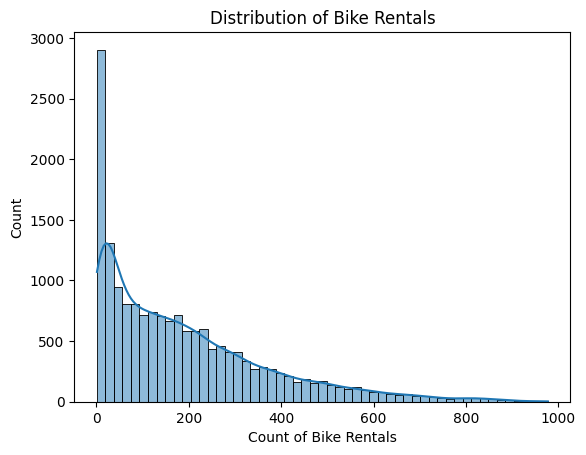

In [8]:
# Distribution of histogram of the "cnt" variable (overall pattern of bike usage)
sns.histplot(df_hour['cnt'], kde=True) # Changed kde-True to kde=True
plt.title("Distribution of Bike Rentals")
plt.xlabel("Count of Bike Rentals")
#plt.ylabel("Frequency")
plt.show()

Histogram illustrates the distribution of bike rentals, with the x-axis representing the count of bike rentals and the y-axis representing the frequency or count of occurrences. The distribution is heavily right-skewed, indicating that a large number of rental counts are clustered around lower values, with progressively fewer occurrences as the rental count increases. It suggests that low bike rental counts are much more common than higher rental counts.

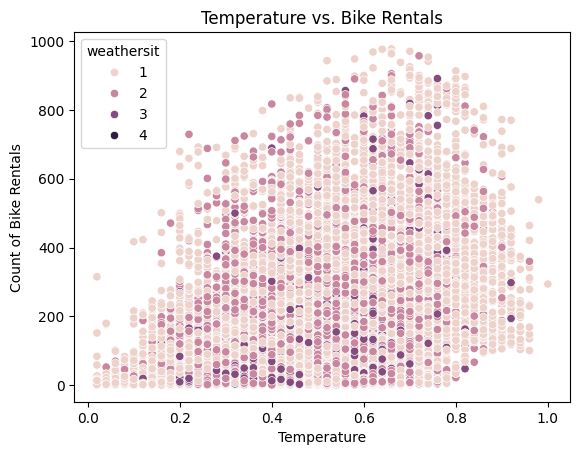

In [9]:
# Scatterplot of temperature, weather, and bike rentals
sns.scatterplot(data=df_hour, x='temp', y='cnt', hue='weathersit')
plt.title("Temperature vs. Bike Rentals")
plt.xlabel("Temperature")
plt.ylabel("Count of Bike Rentals")
plt.show()

The scatterplot provides the relationship between temperature and the count of bike rentals, where x-axis represents temperature, while the y-axis shows the count of bike rentals. Different hues correspond to weather situations (indicated by values 1 through 4 in the legend), with lighter hues representing more favorable weather conditions and darker hues indicating less favorable weather. According to scatterplot, bike rentals generally increase with temperature, suggesting a positive correlation, and the variation in rental counts is affected by different weather conditions.

# **Correlation Analysis**

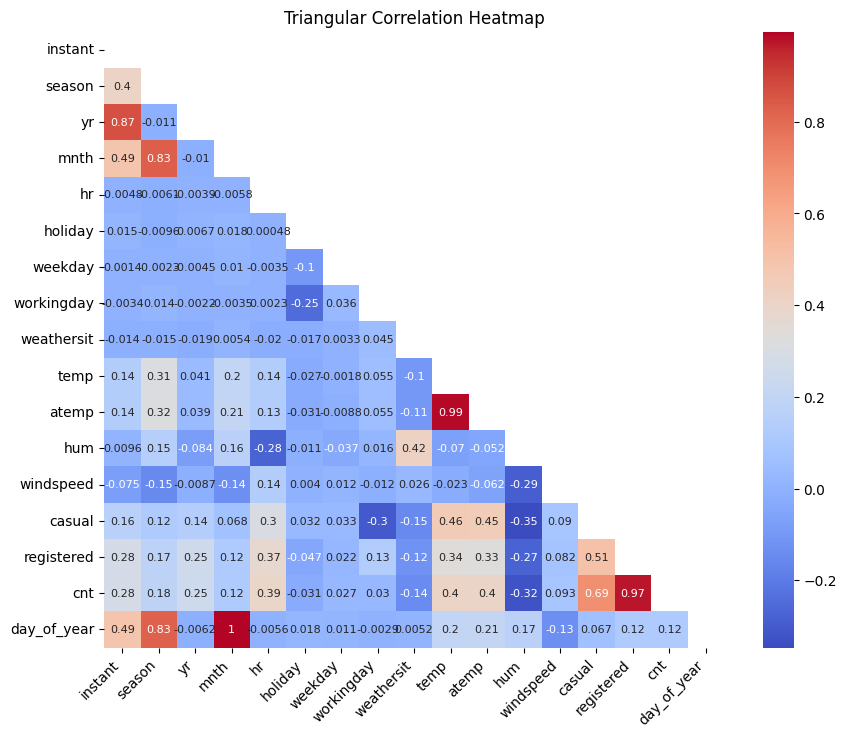

In [10]:
# Creating the correlation matrix
corr = df_hour.drop(columns=['dteday']).corr()

# Creating a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Creating the heatmap with the mask
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Triangular Correlation Heatmap')
plt.show()

The triangular correlation heatmap shows the relationships between different variables in the bike-sharing dataset. lets explore them:


1.   **Temperature and Bike Rentals:** The total count of bike rentals ("cnt") is positively correlated with "temp" (0.40) and "atemp" (0.45). This means that bike rentals tend to increase with higher temperatures.


2.   **Yearly Growth:** The "yr" variable has a strong positive correlation (0.57) with "cnt", indicating that bike rentals increased in the second year compared to the first year.


3.   **Registered vs. Casual Users:** The total count ("cnt") is highly correlated with "registered" users (0.97) and moderately correlated with "casual" users (0.69). Registered users contribute significantly more to total rentals compared to casual users.

4.   **Weather Impact:** Poor weather conditions ("weathersit") and high humidity ("hum") have negative correlations with "cnt" (-0.14 and -0.32, respectively), meaning fewer rentals occur during bad weather or when humidity is high.


1.   **Working Day Effect:** "workingday" is negatively correlated with "casual" users (-0.35), indicating that casual users are less likely to rent bikes on working days, possibly preferring weekends or holidays.


The triangular correlation heatmap reveals several important relationships in the bike-sharing data. Temperature, year, and registered users are key drivers of bike rentals, meaning that rentals increase with higher temperatures, in the second year, and when more registered users are present. On the other hand, adverse weather conditions and high humidity are associated with decreased bike rentals. These insights provide valuable guidance for understanding bike rental trends and can assist in building effective predictive models.

# **Temporal Analysis**

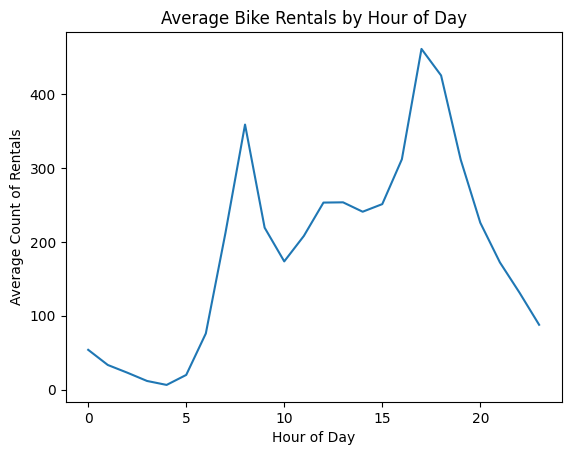

In [11]:
# showing how the number of rentals varies throughout the day by aggregating the "cnt" by the "hr" column
hourly_trend = df_hour.groupby('hr')['cnt'].mean()
hourly_trend.plot(kind='line', title='Average Bike Rentals by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count of Rentals')
plt.show()

The line plot provides the average count of bike rentals throughout the hours of the day, where x-axis represents the hour of the day (ranging from 0 to 23), while the y-axis shows the average count of rentals. The plot reveals two prominent peaks: one in the early morning hours, likely corresponding to commuters, and another in the late afternoon to early evening, which may correspond to people returning home or engaging in evening activities. Bike rentals are lowest in the early morning hours, around 3 to 5 AM, and gradually increase as the day progresses, showing distinct usage patterns related to daily routines.

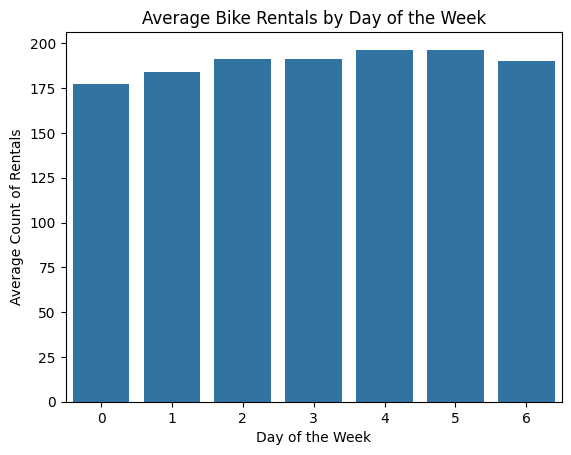

In [12]:
# showing how bike rentals vary across weekdays using weekday
weekday_trend = df_hour.groupby('weekday')['cnt'].mean()
sns.barplot(x=weekday_trend.index, y=weekday_trend.values)
plt.title('Average Bike Rentals by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Count of Rentals')
plt.show()

Bar plot shows the average count of bike rentals by day of the week, where x-axis represents the days of the week, coded numerically from 0 to 6, while the y-axis indicates the average count of rentals. The bars appear relatively similar in height, suggesting that bike rentals remain fairly consistent throughout the week, with only slight variations between days. This implies that bike usage does not significantly change from one day to another, possibly reflecting consistent demand across weekdays and weekends.

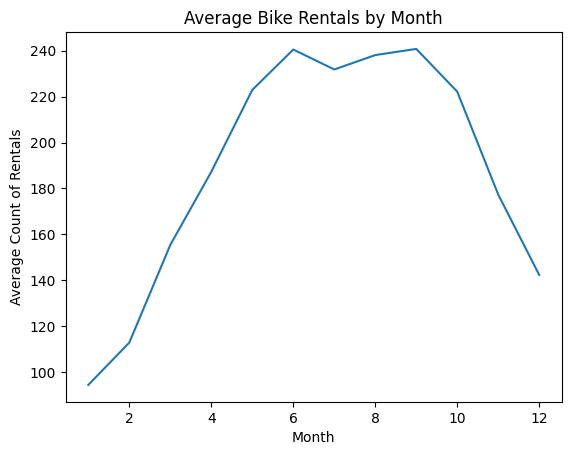

In [13]:
# Evaluating monthly trends for the seasonal effects
monthly_trend = df_hour.groupby('mnth')['cnt'].mean()
sns.lineplot(x=monthly_trend.index, y=monthly_trend.values)
plt.title('Average Bike Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Count of Rentals')
plt.show()

The line plot illustrates the average count of bike rentals over the months of the year, where x-axis represents the months, numbered from 1 (January) to 12 (December), and the y-axis indicates the average count of rentals. The plot shows a clear upward trend from the beginning of the year, peaking around the summer months (June to August), before declining towards the end of the year. This pattern suggests that bike rentals are higher during warmer months, likely due to more favorable weather conditions, and decrease in colder months.

# **Categorical Feature Analysis**

<function matplotlib.pyplot.show(close=None, block=None)>

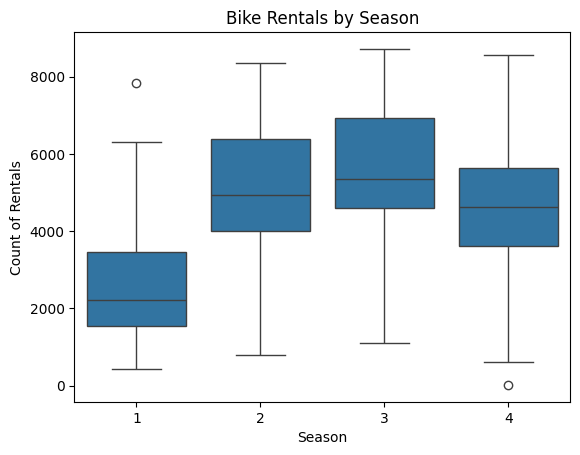

In [14]:
# bike rentals across different seasons ("season") or weather situations ("weathersit")
sns.boxplot(x='season', y='cnt', data=df_day)
plt.title('Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Count of Rentals')
plt.show

This box plot represents the distribution of bike rental counts across different seasons, where x-axis shows the seasons (labeled numerically from 1 to 4), and the y-axis indicates the count of bike rentals. Each box represents the interquartile range (IQR), with the line inside the box indicating the median number of rentals. The whiskers extend to show the range of the data, excluding outliers, which are plotted as individual points. The plot shows that bike rentals tend to be lower in season 1 and higher in seasons 2 and 3, suggesting that seasonal changes significantly impact bike rental activity. Season 4 has a moderate number of rentals but shows some variation, with outliers present.

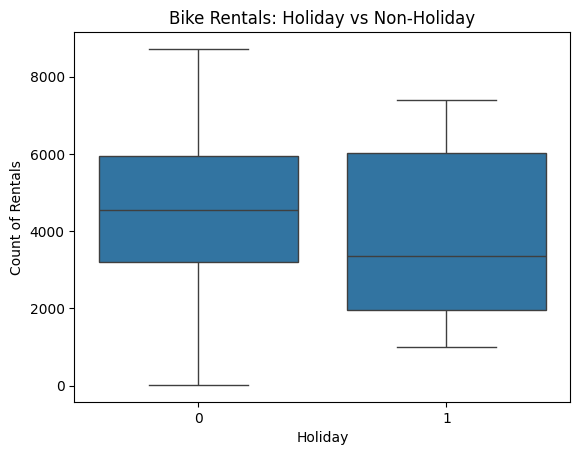

In [15]:
# Comparing the average rentals during holidays (holiday == 1) vs non-holidays
sns.boxplot(x='holiday', y='cnt', data=df_day)
plt.title('Bike Rentals: Holiday vs Non-Holiday')
plt.xlabel('Holiday')
plt.ylabel('Count of Rentals')
plt.show()

This box plot compares the distribution of bike rental counts on non-holidays (0) versus holidays (1). It shows that bike rentals are generally lower on holidays, with a wider spread and a lower median compared to non-holidays.

# **Seasonality Analysis**

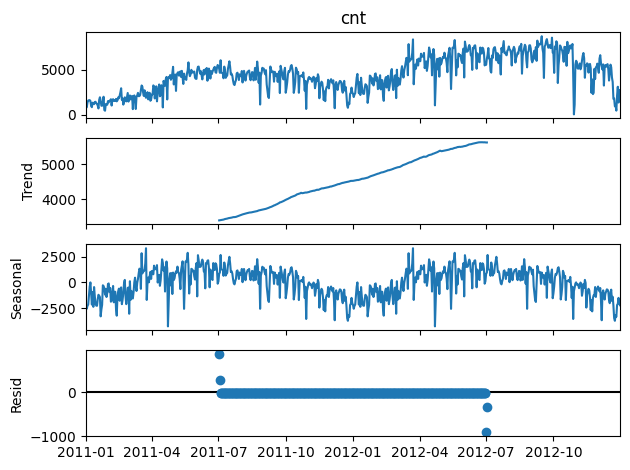

In [16]:
# useing seasonal decomposition to break down the time series into trend, seasonal, and residual components

result = seasonal_decompose(df_day['cnt'], model='additive', period=365)
result.plot()
plt.show()

This time series decomposition plot breaks down the "cnt" (count of bike rentals) into three components: "trend", "seasonal", and "residual". This plot suggests that bike rentals have been steadily increasing over time, with noticeable patterns that repeat, likely due to seasons or specific times of the year. However, there are some fluctuations and unexpected variations that can't be fully explained by these patterns, hinting at the influence of random or external factors.

# **Outlier Detection**

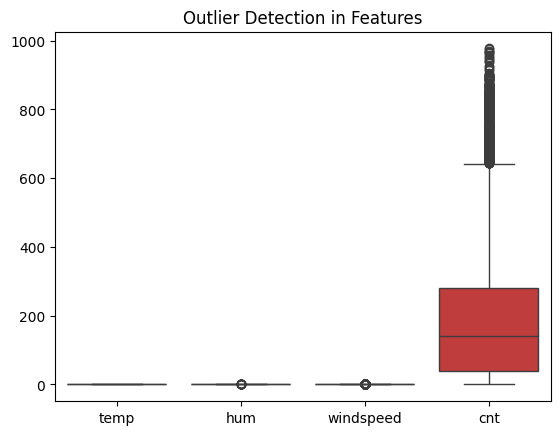

In [17]:
# detect any anomalies in the dataset
sns.boxplot(data=df_hour[['temp', 'hum', 'windspeed', 'cnt']])
plt.title('Outlier Detection in Features')
plt.show()

According to box plot while "temp", "hum", and "windspeed" have relatively few or minor outliers, the "cnt" feature shows many high-value outliers, suggesting that there are days with unusually high bike rental counts compared to the rest.

# **Feature Engineering Ideas**

In [18]:
# Creating a new feature combining holiday and weekend indicators
df_hour['day_type'] = np.where((df_hour['holiday'] == 1) | (df_hour['weekday'].isin([0, 6])), 'off_day', 'working_day')

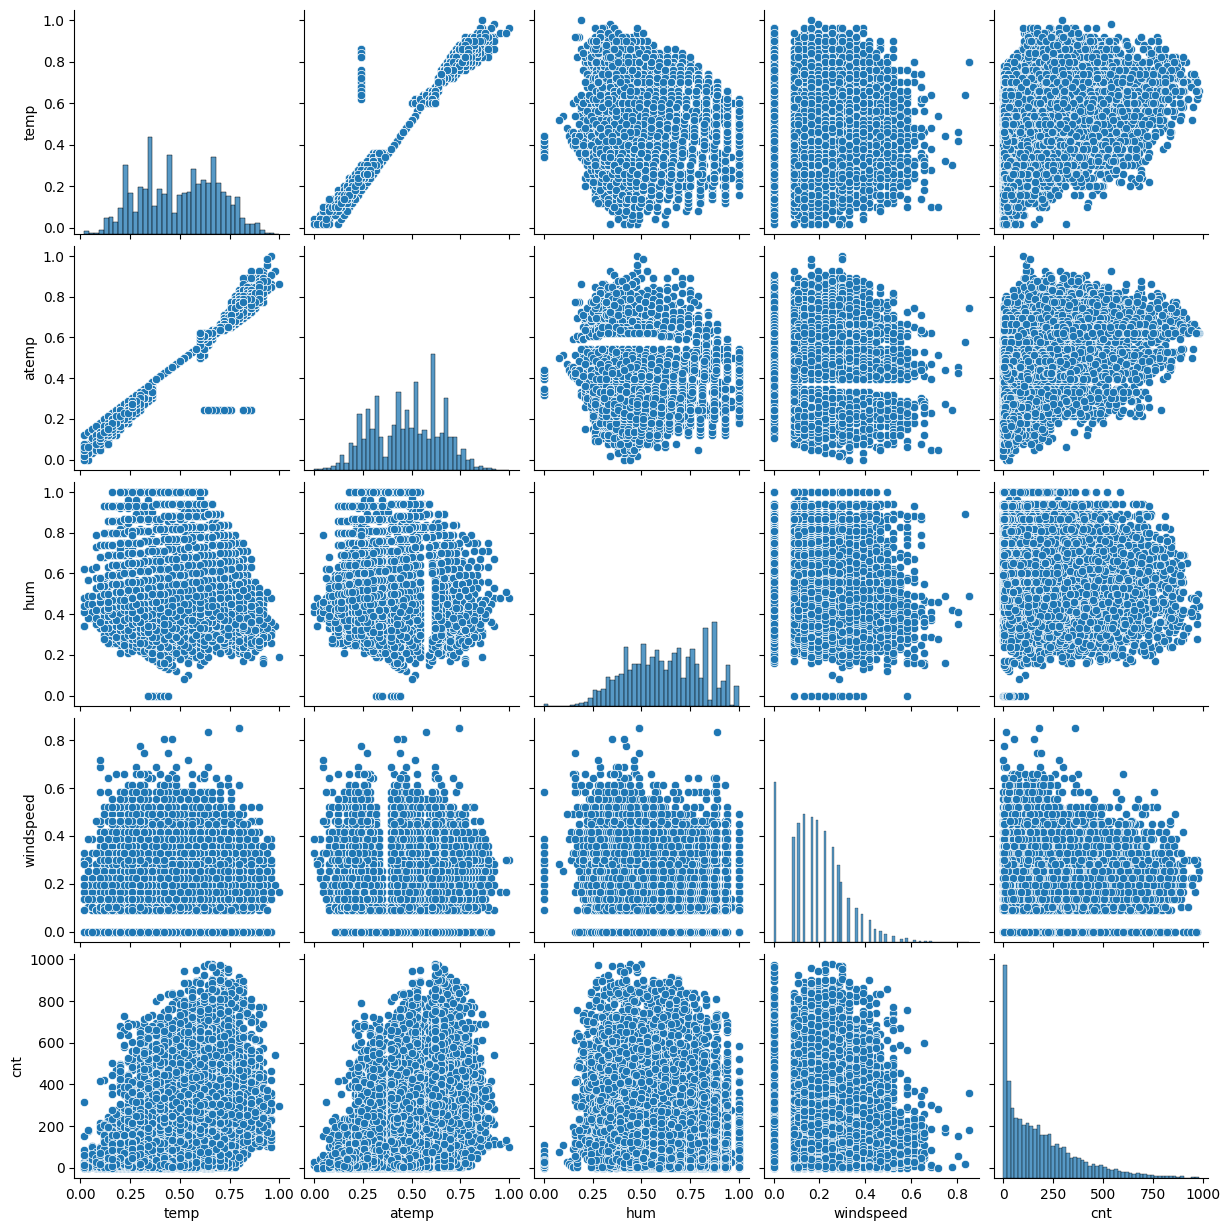

In [19]:
# Visualizing relationships between key features like "temp", 'atemp', "hum', "windspeed", and "cnt"
sns.pairplot(df_hour[['temp', 'atemp', 'hum', 'windspeed', 'cnt']])
plt.show()


This pair plot visualizes relationships between the features "temp", "atemp", "hum", "windspeed", and "cnt". It provides insights into potential correlations and distributions within the dataset. A strong positive linear relationship is evident between "temp" and "atemp", indicating these features are closely related. The scatter plots also show a positive correlation between temperature features ("temp" and "atemp") and bike rental counts ("cnt"), suggesting that higher temperatures may be associated with more rentals. Other features, like "windspeed", do not exhibit a clear relationship with "cnt".

# **Time Series Stationarity Check**


<Axes: title={'center': 'Bike Rentals Time Series'}, xlabel='dteday'>

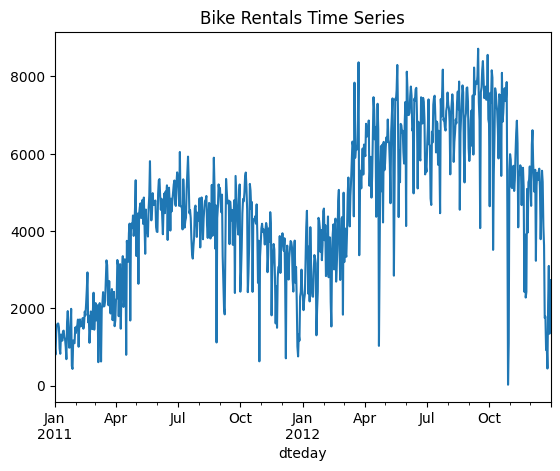

In [20]:
# Time series plot for obvious trends or sesonality
df_day['cnt'].plot(title='Bike Rentals Time Series')

The time series plot shows the original bike rental data over time. It has a clear upward trend, indicating that the average number of rentals increases over the period. Additionally, there are visible fluctuations, suggesting some potential seasonality or irregular variations.

<Axes: title={'center': 'Differenced Bike Rentals Time Series'}, xlabel='dteday'>

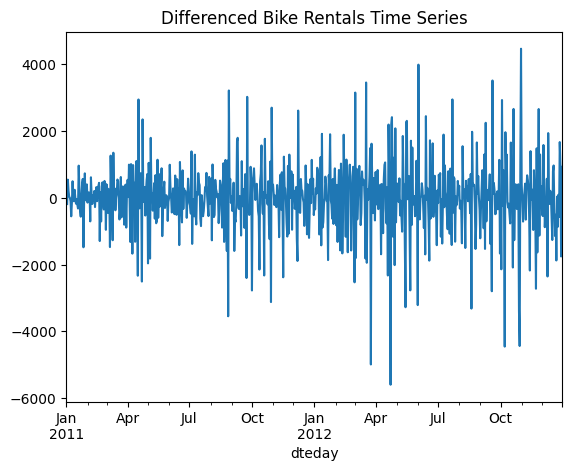

In [21]:
# Applying differencing
df_day['cnt_diff'] = df_day['cnt'].diff().dropna()
df_day['cnt_diff'].plot(title='Differenced Bike Rentals Time Series')

The differenced time series plot displays the data after applying first-order differencing. This transformation has removed the trend, making the series more stationary, as the values now fluctuate around a mean of zero.

# **Seasonal Autocorrelation Plot**

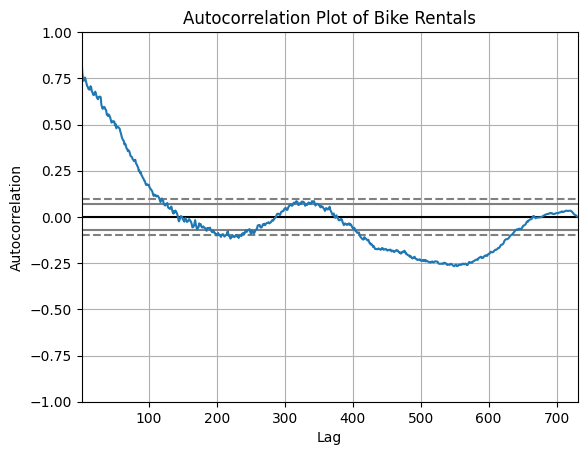

In [22]:
# Check for lag correlation
autocorrelation_plot(df_day['cnt'])
plt.title('Autocorrelation Plot of Bike Rentals')
plt.show()

This autocorrelation plot shows how the bike rental counts are correlated with their own past values over different time lags. It starts high at lag 0 and gradually decreases, suggesting that the series has significant autocorrelation at short lags, which diminishes over time. As the lag increases (e.g., moving from 0 to 100, 200, etc.), the autocorrelation drops, meaning that the relationship between the current and past values weakens. The presence of autocorrelation over several lags indicates that past values of bike rentals are informative for predicting future values, and it may suggest the need for further differencing or the inclusion of autoregressive terms in a forecasting model.



# Metrics and Evalulations

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Example: Simulated data (replace with your actual time series data)
# Replace this with your dataset
np.random.seed(42)
n = 120  # Number of observations
data = pd.Series(np.sin(np.linspace(0, 20, n)) + np.random.normal(0, 0.2, n))

# Splitting data into training (90%) and testing (10%) sets
train_size = int(len(data) * 0.9)
train_data = data[:train_size]
test_data = data[train_size:]

# Fit ARIMA model with seasonal component using auto_arima
model = auto_arima(
    train_data,
    seasonal=True,      # Enable seasonal component
    m=12,               # Set seasonality period (e.g., 12 for monthly data)
    trace=True,         # Output detailed information about the process
    suppress_warnings=True,
    stepwise=True       # Perform stepwise search to optimize parameters
)




Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=242.864, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=35.755, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=130.259, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=240.868, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=35.144, Time=0.01 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=34.988, Time=0.03 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=36.018, Time=0.06 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=33.992, Time=0.20 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=34.839, Time=0.21 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=180.743, Time=0.15 sec
 ARIMA(2,0,0)(0,0,2)[12] intercept   : AIC=30.679, Time=0.15 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=30.986, Time=0.05 sec
 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=30.413, Time=0.30 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=32.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(5, 0, 1)   Log Likelihood                  14.273
Date:                Sat, 07 Dec 2024   AIC                            -14.546
Time:                        22:08:49   BIC                              4.229
Sample:                             0   HQIC                            -6.933
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2439      0.121     10.269      0.000       1.006       1.481
ar.L2         -0.0495      0.187     -0.265      0.791      -0.416       0.317
ar.L3         -0.0048      0.172     -0.028      0.9

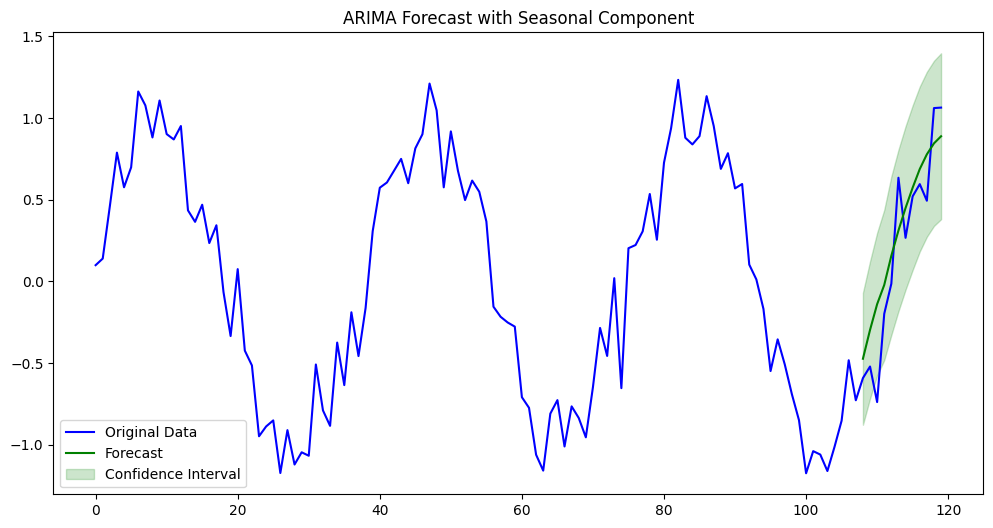

Mean Squared Error (MSE): 0.06583233625519282


In [24]:
# Summary of the model
print(model.summary())

# Forecasting the test set
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data, label="Original Data", color="blue")
plt.plot(range(train_size, len(data)), forecast, label="Forecast", color="green")
plt.fill_between(
    range(train_size, len(data)),
    conf_int[:, 0],
    conf_int[:, 1],
    color="green",
    alpha=0.2,
    label="Confidence Interval"
)
plt.legend()
plt.title("ARIMA Forecast with Seasonal Component")
plt.show()

# Calculate performance metrics (e.g., Mean Squared Error)ßßß
mse = mean_squared_error(test_data, forecast)
print(f"Mean Squared Error (MSE): {mse}")

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
#------------------------------------------------------------
# Step 1: Load Hourly Data
#------------------------------------------------------------
# Load the hourly bike rental data. Ensure 'hour.csv' is in your working directory.

bike_data = pd.read_csv('/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/hour.csv', index_col='dteday', parse_dates=True)

# Extract the target variable
data = bike_data[['cnt']].values  # shape: (n_samples, 1)

# Normalize the data to [0,1] for stable training
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [5]:
#------------------------------------------------------------
# Step 2: Create Sequences for Supervised Learning
#------------------------------------------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 182  # Number of days to look back
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape X for LSTM: (samples, timesteps, features)
# Already in correct shape if using univariate data; shape is (samples, seq_length, 1)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (13757, 182, 1)
X_test shape: (3440, 182, 1)


In [6]:
#------------------------------------------------------------
# Step 3: Build the LSTM Model
#------------------------------------------------------------
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

#------------------------------------------------------------
# Step 4: Train the Model
#------------------------------------------------------------
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    verbose=1)

#------------------------------------------------------------
# Step 5: Evaluate and Predict
#------------------------------------------------------------
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # invert scaling
y_test_actual = scaler.inverse_transform(y_test)     # invert scaling


/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 182, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 182, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0222 - mae: 0.1084 - val_loss: 0.0190 - val_mae: 0.0923
Epoch 2/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - loss: 0.0096 - mae: 0.0676 - val_loss: 0.0114 - val_mae: 0.0713
Epoch 3/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0067 - mae: 0.0562 - val_loss: 0.0089 - val_mae: 0.0621
Epoch 4/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0058 - mae: 0.0517 - val_loss: 0.0075 - val_mae: 0.0613
Epoch 5/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - loss: 0.0051 - mae: 0.0494 - val_loss: 0.0071 - val_mae: 0.0544
Epoch 6/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0044 - mae: 0.0451 - val_loss: 0.0050 - val_mae: 0.0477
Epoch 7/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0040 - mae: 0.0433 - val_loss: 0.0054 - val_mae: 0.0472
Epoch 8/100
430/430 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0037 - mae: 0.0414 - val_loss: 0.0045 - val_mae: 0.0454
Epoch 9/100
430/430 ━━━━━━━━━━━━

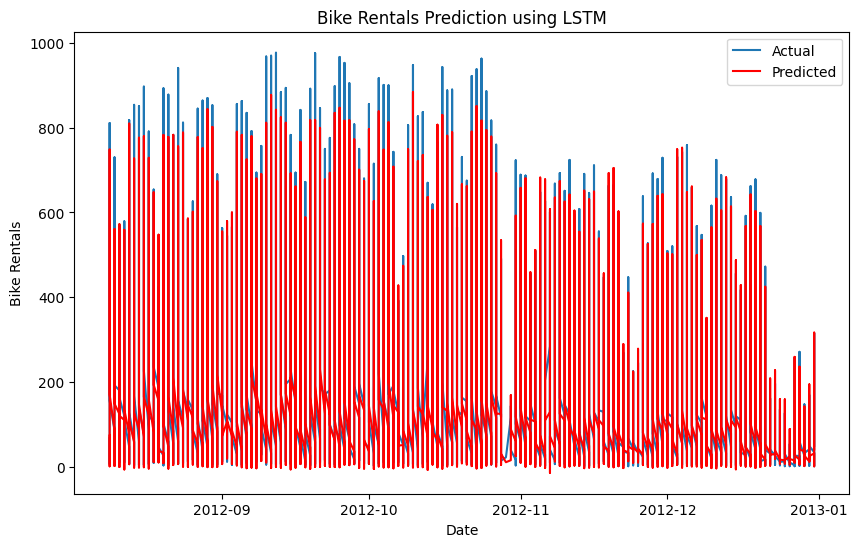

In [7]:

#------------------------------------------------------------
# Step 6: Plot the Results
#------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(bike_data.index[-len(y_test):], y_test_actual, label='Actual')
plt.plot(bike_data.index[-len(y_test):], predictions, label='Predicted', color='red')
plt.title('Bike Rentals Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()
#------------------------------------------------------------
# Notes:
#------------------------------------------------------------
# - You can experiment with seq_length to capture longer patterns.
# - Consider using additional features (e.g., temperature, season, etc.) to make it a multivariate LSTM.
# - Tune hyperparameters (LSTM units, dropout, epochs) for better results.
# - For complex data patterns, consider Stacked LSTM, Bidirectional LSTM, or even CNN-LSTM hybrid architectures.


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'y_test_actual' and 'predictions' are already defined:
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 2156.93
Root Mean Squared Error (RMSE): 46.44
Mean Absolute Error (MAE): 30.00
R² Score: 0.9554


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

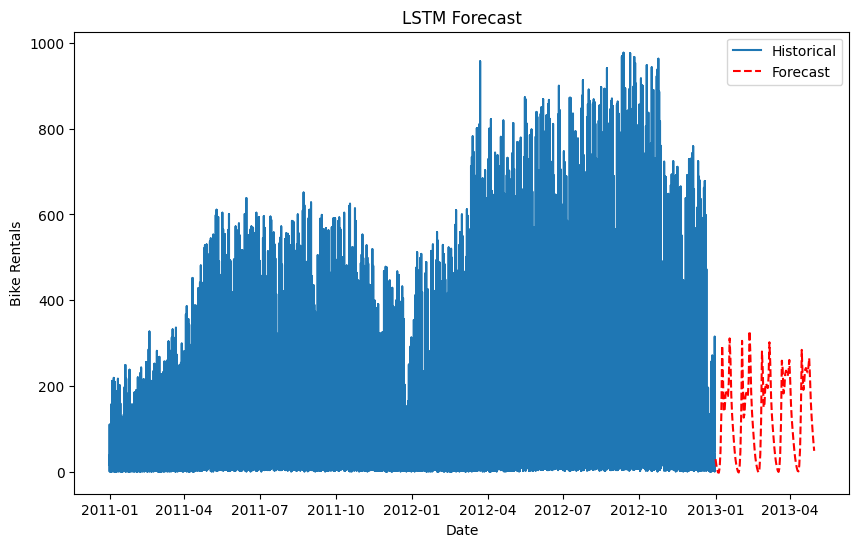

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
# Get the last 'seq_length' data points from your dataset
last_sequence = scaled_data[-seq_length:]  # shape: (seq_length, 1)

# Number of days you want to forecast into the future
future_days = 120

future_predictions_scaled = []

# Iteratively predict future values
current_sequence = last_sequence.copy()
for _ in range(future_days):
    # Model expects input of shape (batch_size, seq_length, features)
    pred = model.predict(current_sequence.reshape(1, seq_length, 1))
    
    # Append prediction
    future_predictions_scaled.append(pred[0,0])
    
    # Update the sequence: remove the first element and add the newly predicted one
    current_sequence = np.append(current_sequence[1:], pred[0,0])
    current_sequence = current_sequence.reshape(seq_length, 1)

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

# Build a forecast date range
last_date = bike_data.index[-1]
future_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Plot the historical data and forecasts
plt.figure(figsize=(10,6))
plt.plot(bike_data.index, bike_data['cnt'], label='Historical')
plt.plot(future_index, future_predictions, label='Forecast', color='red', linestyle='--')
plt.title('LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()

----


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import itertools

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import sktime
import warnings
warnings.filterwarnings("ignore")

# Load the bike sharing day dataset
bike_data = pd.read_csv('day.csv', parse_dates=['dteday'], index_col='dteday')


In [7]:
# Set target and exogenous variables
y = bike_data['cnt']
exog_vars = ['temp', 'atemp', 'hum', 'windspeed', 'holiday', 'workingday', 
             'weathersit', 'season', 'yr', 'mnth', 'weekday']
X = bike_data[exog_vars]

# Split into train/test
train_size = int(len(y)*0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

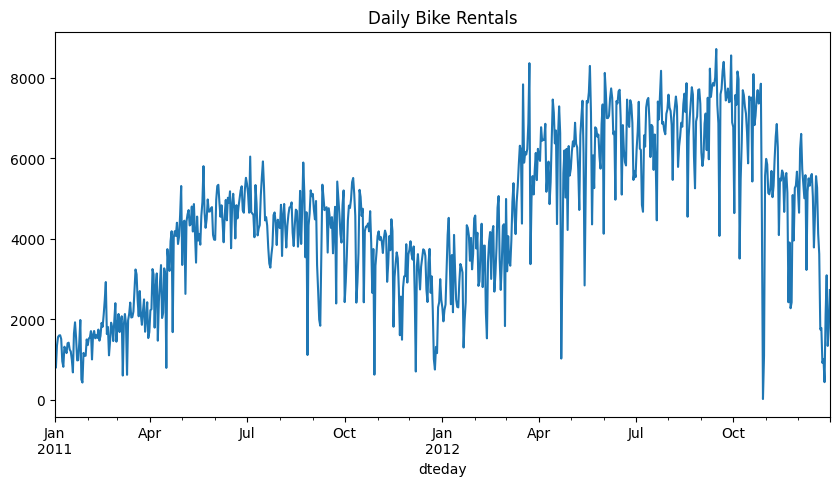

In [8]:
y.plot(title='Daily Bike Rentals', figsize=(10,5))
plt.show()

In [10]:
p = range(0, 6)    # AR terms
d = [0, 1]         # Differencing terms
q = range(0, 6)    # MA terms

P = range(0, 2)    # Seasonal AR terms
D = [0, 1]         # Seasonal differencing
Q = range(0, 2)    # Seasonal MA terms

m = [7]  # weekly seasonality

In [11]:
best_aic = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

for pdq in itertools.product(p, d, q):
    for PDQ in itertools.product(P, D, Q, m):
        try:
            mod = SARIMAX(y_train, 
                          exog=X_train, 
                          order=pdq, 
                          seasonal_order=PDQ,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = pdq
                best_seasonal_order = PDQ
                best_model = results
        except:
            # If the model fails to converge or fit, just skip
            continue

In [12]:
print("Best SARIMAX model found:")
print("Non-seasonal ARIMA order:", best_order)
print("Seasonal ARIMA order:", best_seasonal_order)
print("AIC:", best_aic)

Best SARIMAX model found:
Non-seasonal ARIMA order: (1, 0, 5)
Seasonal ARIMA order: (0, 1, 1, 7)
AIC: 9002.386222302906


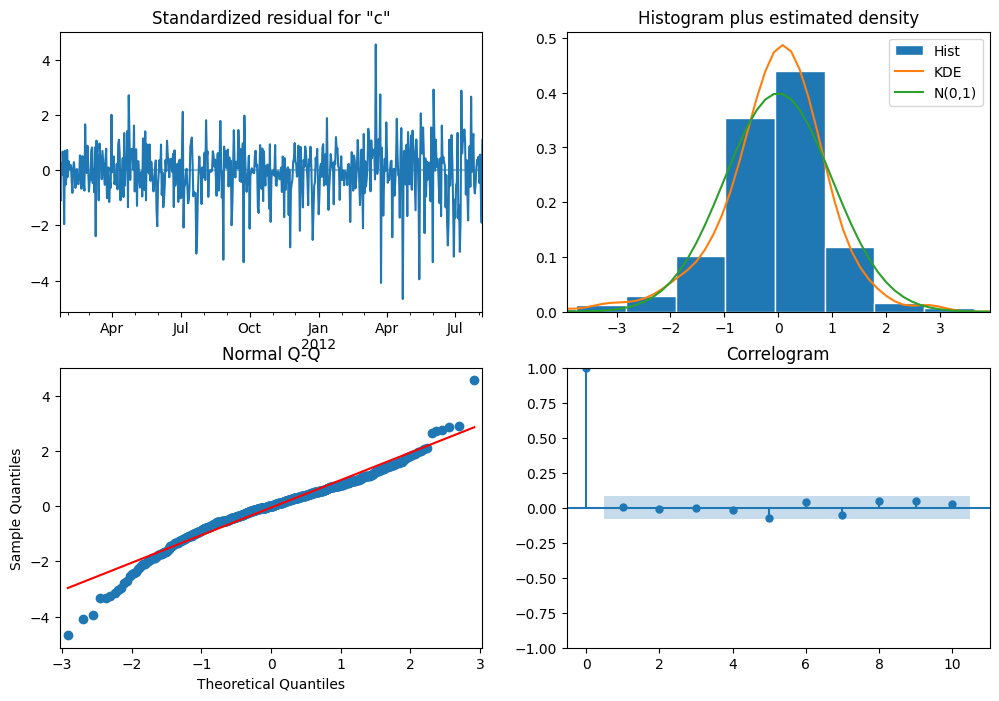

In [13]:
best_model.plot_diagnostics(figsize=(12,8))
plt.show()

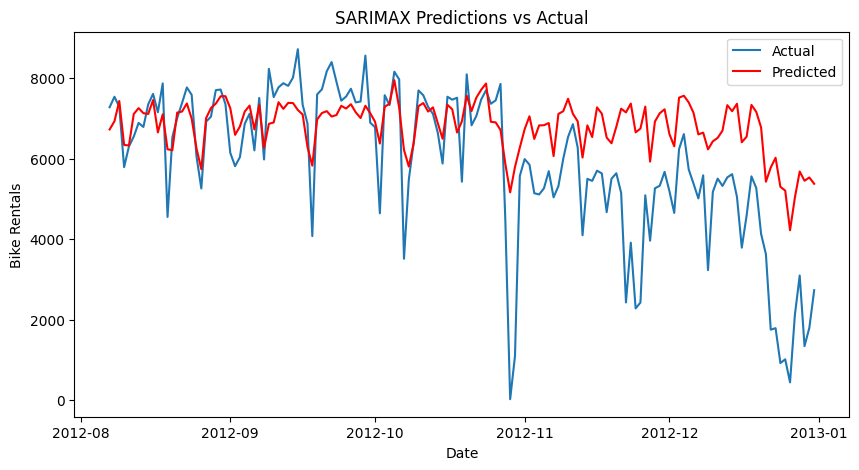

In [14]:
y_pred = best_model.predict(start=len(y_train), end=len(y)-1, exog=X_test)

plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', color='red')
plt.title('SARIMAX Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()

In [15]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("Test RMSE:", rmse)
print("Test MAE:", mae)

Test RMSE: 1706.4822292403412
Test MAE: 1237.6292016938996


In [16]:
final_model = SARIMAX(y, exog=X, 
                      order=best_order, 
                      seasonal_order=best_seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False).fit(disp=False)

# Example: predict next 30 days (assuming you have future exog data)
# For demonstration, we just re-use the last known exog values or create a placeholder
future_steps = 30
future_index = pd.date_range(start=y.index[-1] + pd.Timedelta(days=1), periods=future_steps)
# In a real scenario, populate X_future with known or forecasted exogenous values
X_future = X.iloc[-future_steps:].copy()  # This is just a placeholder

future_forecast = final_model.predict(start=len(y), end=len(y)+future_steps-1, exog=X_future)
print("Future Forecast:\n", future_forecast)

Future Forecast:
 2013-01-01    3895.884801
2013-01-02    5517.124647
2013-01-03    5186.917514
2013-01-04    5091.355503
2013-01-05    4995.178862
2013-01-06    3724.026121
2013-01-07    3660.461716
2013-01-08    3620.798895
2013-01-09    4161.052696
2013-01-10    4002.574207
2013-01-11    4381.777744
2013-01-12    5227.230768
2013-01-13    4396.929201
2013-01-14    4471.087790
2013-01-15    3841.298685
2013-01-16    4324.015672
2013-01-17    4979.934632
2013-01-18    4951.223999
2013-01-19    4636.354524
2013-01-20    1988.354187
2013-01-21    2248.749936
2013-01-22    3007.641402
2013-01-23    2539.149798
2013-01-24    1994.567673
2013-01-25    1247.927873
2013-01-26    2273.086174
2013-01-27    2329.559394
2013-01-28    1964.260798
2013-01-29    2443.646900
2013-01-30    2606.188659
Freq: D, Name: predicted_mean, dtype: float64


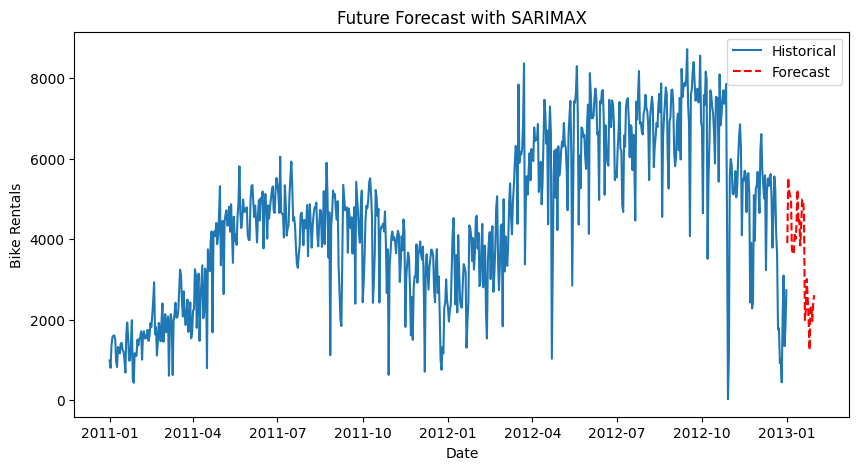

In [17]:
# Plot the historical and forecasted values
plt.figure(figsize=(10,5))
plt.plot(y.index, y, label='Historical')
plt.plot(future_index, future_forecast, label='Forecast', color='red', linestyle='--')
plt.title('Future Forecast with SARIMAX')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()

# Linear Regression

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.952e+06, tolerance: 3.718e+04
  model = cd_fast.enet_coordinate_descent(
/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.920e+06, tolerance: 3.713e+04
  model = cd_fast.enet_coordinate_descent(
/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might wa

Best Params: {'poly__degree': 3, 'regressor': Lasso(), 'regressor__alpha': 0.1}
Best Score (MSE): 6331.494091056289

Model Performance on Test Set:
RMSE: 76.13
MAE: 54.91
R² Score: 0.8170


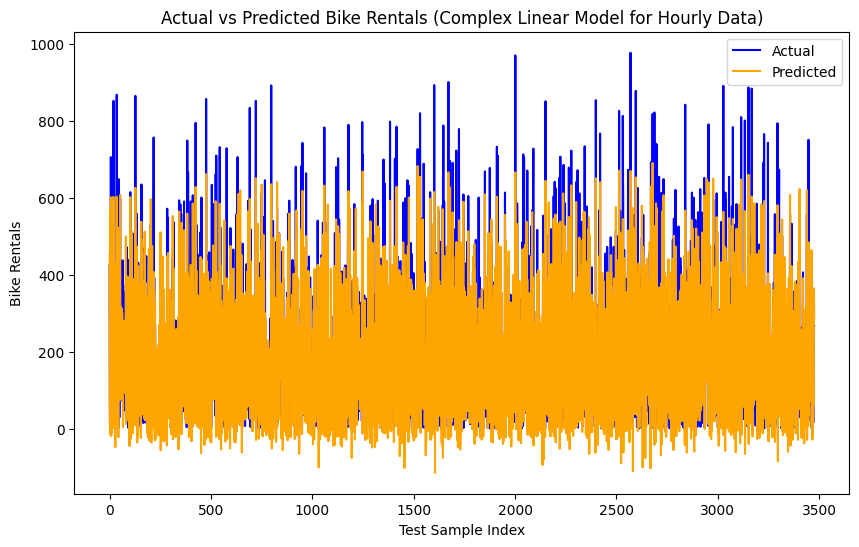

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

#---------------------------------------------------------
# Load Data
#---------------------------------------------------------
# hour.csv has hourly data with features such as hr, season, weathersit, etc.
bike_data = pd.read_csv('hour.csv', parse_dates=['dteday'])

# The target variable
y = bike_data['cnt']

# Potential features. For hourly data, we have 'hr' (0-23), 'season', 'yr', 'mnth', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
# Let's use all of these. You can choose to exclude 'casual', 'registered' since they sum to cnt and are not available for out-of-sample prediction typically.
exog_vars = ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 
             'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

X = bike_data[exog_vars]

#---------------------------------------------------------
# Feature Engineering: Cyclical Encoding for Hour
#---------------------------------------------------------
# Hours of day is cyclical (hr=0 and hr=23 are close).
# Encode hr as sin and cos:
def cyclical_transform_hr(X):
    # X expected to be a dataframe or array including 'hr'
    hr = X['hr'].values
    # sin and cos transforms
    X_transformed = X.copy()
    X_transformed['hr_sin'] = np.sin(2 * np.pi * hr / 24)
    X_transformed['hr_cos'] = np.cos(2 * np.pi * hr / 24)
    X_transformed.drop('hr', axis=1, inplace=True)
    return X_transformed

hr_transformer = FunctionTransformer(cyclical_transform_hr, validate=False)

# Similarly, if we want, we can cyclical encode 'weekday' or 'mnth'. 
# Let's also do weekday cyclical since 7-day weekly cycle:
def cyclical_transform_weekday(X):
    wd = X['weekday'].values
    X_transformed = X.copy()
    X_transformed['wd_sin'] = np.sin(2 * np.pi * wd / 7)
    X_transformed['wd_cos'] = np.cos(2 * np.pi * wd / 7)
    X_transformed.drop('weekday', axis=1, inplace=True)
    return X_transformed

weekday_transformer = FunctionTransformer(cyclical_transform_weekday, validate=False)

# We'll build a pipeline that first applies these transformations

#---------------------------------------------------------
# Train/Test Split
#---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#---------------------------------------------------------
# Pipeline Setup
#---------------------------------------------------------
# The pipeline steps:
# 1. Transform hr and weekday to cyclical
# 2. Scale features
# 3. Polynomial features
# 4. Ridge or Lasso regression

pipeline = Pipeline([
    ('hr_cyc', hr_transformer),
    ('wd_cyc', weekday_transformer),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('regressor', Ridge())  # Placeholder; will be replaced in param_grid search
])

#---------------------------------------------------------
# Hyperparameter Grid
#---------------------------------------------------------
param_grid = {
    'poly__degree': [1, 2, 3],          # Try linear, quadratic, cubic
    'regressor': [Ridge(), Lasso()],    # Try both Ridge and Lasso
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

#---------------------------------------------------------
# Grid Search
#---------------------------------------------------------
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_

#---------------------------------------------------------
# Evaluation on Test Set
#---------------------------------------------------------
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

#---------------------------------------------------------
# Visualization of Predictions
#---------------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Bike Rentals (Complex Linear Model for Hourly Data)')
plt.xlabel('Test Sample Index')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.184e+07, tolerance: 1.919e+05
  model = cd_fast.enet_coordinate_descent(
/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.969e+06, tolerance: 1.919e+05
  model = cd_fast.enet_coordinate_descent(
/Users/home/Documents/GitHub/ADS-506-Final-Team-Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might wa

Best Params: {'poly__degree': 3, 'regressor': Lasso(), 'regressor__alpha': 10}
Best Score (MSE): 405378.9815877805

Model Performance on Test Set:
RMSE: 663.43
MAE: 432.06
R² Score: 0.9000


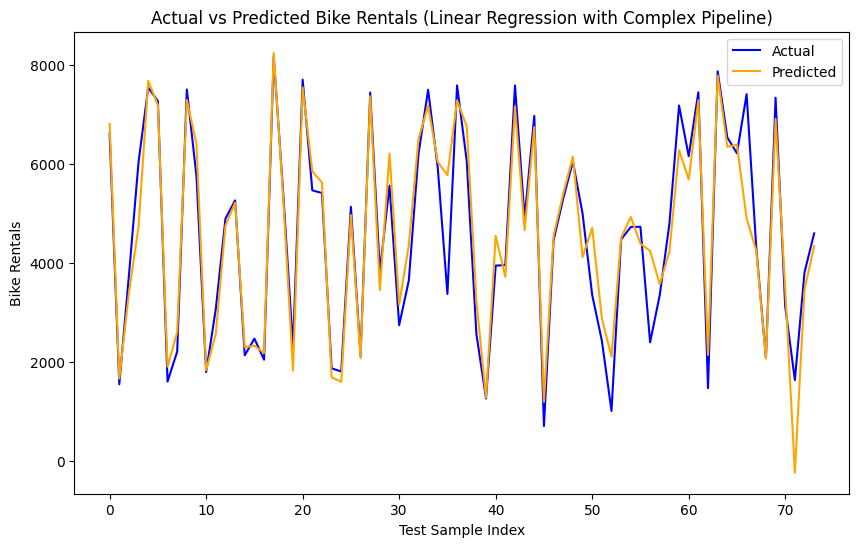

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

warnings.filterwarnings("ignore")

#---------------------
# Load and Prepare Data
#---------------------
# Make sure 'day.csv' is in the working directory.
bike_data = pd.read_csv('day.csv', parse_dates=['dteday'], index_col='dteday')

# Target variable
y = bike_data['cnt']

# Example exogenous variables (adjust as needed):
# Using a broad range including season, holiday, workingday, weather, and continuous variables like temp, hum
exog_vars = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 
             'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X = bike_data[exog_vars]

# Optional: If you have performed additional feature engineering (like lag features, interactions), include them.
# For complexity demonstration, let's just rely on polynomial features in the pipeline below.

#---------------------
# Train/Test Split
#---------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#---------------------
# Pipeline Setup
#---------------------
# We create a pipeline to:
# 1. Scale features
# 2. Add polynomial features
# 3. Apply a regularized linear model (Ridge or Lasso)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),  # We'll tune the degree
    # We'll choose Ridge or Lasso within the grid search
    ('regressor', Ridge())  # Placeholder; will tune hyperparameters
])

#---------------------
# Hyperparameter Grid
#---------------------
# We'll try both Ridge and Lasso by passing different models in the grid,
# or we can do separate searches. Here we show a single search focusing on Ridge first.
# Then you can try Lasso by changing 'regressor' step or by using a parameter that toggles model type.

param_grid = {
    'poly__degree': [1, 2, 3],  # polynomial degrees
    'regressor': [Ridge(), Lasso()],  # try both Ridge and Lasso
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]  # strength of regularization
}

#---------------------
# Grid Search
#---------------------
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

best_model = grid_search.best_estimator_

#---------------------
# Evaluation on Test Set
#---------------------
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

#---------------------
# Visualization
#---------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Bike Rentals (Linear Regression with Complex Pipeline)')
plt.xlabel('Test Sample Index')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()